In [16]:
from pprint import pprint

from langchain_core.messages import HumanMessage, AIMessage

messages = [AIMessage(content=f"So you said you are searching for ocean mammals?", name ="Model")]
messages.append(HumanMessage(content="Yes, I am searching for ocean mammals", name="Hrithik"))
messages.append(AIMessage(content="Great!, What would you like to know about ocean mammals?", name="Model"))
messages.append(HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Hrithik"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you are searching for ocean mammals?
================================ Human Message =================================
Name: Hrithik

Yes, I am searching for ocean mammals
================================== Ai Message ==================================
Name: Model

Great!, What would you like to know about ocean mammals?
================================ Human Message =================================
Name: Hrithik

I want to learn about the best place to see Orcas in the US.


In [17]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

In [27]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiplies a and b.

    Args:
        a: The first number to multiply.
        b: The second number to multiply.

    Returns:
        The product of a and b.
    """
    return a * b

multiply.run({"a": 2, "b": 3})

6

In [19]:
llm_with_tools = llm.bind_tools([multiply])

tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 times 3?", name="Hrithik")])

tool_call.additional_kwargs["tool_calls"]


[{'id': 'call_Fa3GTd2nwdC3dHrfbCQ4usmb',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

In [32]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing import TypedDict
from langchain_core.messages import AnyMessage


class Messages(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [30]:
from langgraph.graph import MessagesState

class MessagesState(TypedDict):
    pass

In [33]:
from langgraph.types import Command
from langgraph.graph import END, START, StateGraph
from typing import Literal


#node 
def tool_call_node(state: Messages) -> Command[Literal["__end__"]]:
    """
    Based on the state messages, decide if we need to call the tool or not.
    """
    return Command(
        update = {
            "messages": [llm_with_tools.invoke(state["messages"])]
        },
        goto = END
    )

workflow = StateGraph(Messages)

workflow.add_node("tool_call_node", tool_call_node)

workflow.add_edge(START, "tool_call_node")


graph = workflow.compile()


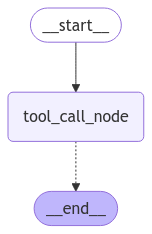

In [34]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
messages = graph.invoke({"messages": HumanMessage(content = "What is 2 times 3?", name = "Hrithik")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================
Name: Hrithik

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_XBOi52njAJUF6iqRuF8hjxQq)
 Call ID: call_XBOi52njAJUF6iqRuF8hjxQq
  Args:
    a: 2
    b: 3


In [44]:
print(messages["messages"][-1])

content='' additional_kwargs={'tool_calls': [{'id': 'call_XBOi52njAJUF6iqRuF8hjxQq', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 86, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-3af45002-656f-4a6b-af47-716370af3572-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_XBOi52njAJUF6iqRuF8hjxQq', 'type': 'tool_call'}] usage_metadata={'input_tokens': 86, 'output_tokens': 18, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
